In [1]:
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm
import pickle
import gc

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import catboost as cb
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Train/test split

For a sake of the programming assignment, let's artificially split the data into train and test. We will treat last month data as the test set.

In [2]:
# Will we save intermediate models?
save_models = True

In [3]:
all_data = pd.read_parquet('data/all_data.parquet')
# print('Columns:', all_data.columns)
all_data.info()
all_data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 0 to 6639293
Data columns (total 84 columns):
 #   Column                                 Dtype  
---  ------                                 -----  
 0   shop_id                                int32  
 1   item_id                                int32  
 2   date_block_num                         int32  
 3   item_category_id                       int32  
 4   target                                 float32
 5   target_shop_date                       float32
 6   target_item_date                       float32
 7   target_item_shop_date                  float32
 8   target_item-cat_date                   float32
 9   target_shop_item-cat_date              float32
 10  target_mean                            float32
 11  target_shop_date_mean                  float32
 12  target_item_date_mean                  float32
 13  target_item_shop_date_mean             float32
 14  target_item-cat_date_mean              float32
 15

,shop_id,item_id,date_block_num,item_category_id,target,target_shop_date,target_item_date,target_item_shop_date,target_item-cat_date,target_shop_item-cat_date,...,target_shop_item-cat_date_lag_12,target_shop_item-cat_date_mean_lag_12,city_code,type_code,subtype_code,month_num,item_first_sale,item_shop_first_sale,days,delta_price_lag
0,59,944,12,37,1.0,1491.0,23.0,1.0,7511.0,104.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
1,59,21861,12,37,1.0,1491.0,62.0,1.0,7511.0,104.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
2,59,21455,12,37,1.0,1491.0,20.0,1.0,7511.0,104.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
3,59,33,12,37,2.0,1491.0,42.0,2.0,7511.0,104.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
4,59,19750,12,37,1.0,1491.0,8.0,1.0,7511.0,104.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6639289,45,18454,34,55,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,20,13,2,10,11,11,30,-0.475305
6639290,45,16188,34,64,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,20,14,42,10,2,2,30,0.081167
6639291,45,15757,34,55,0.0,0.0,0.0,0.0,0.0,0.0,...,124.0,124.0,20,13,2,10,22,22,30,0.155905
6639292,45,19648,34,40,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,20,11,4,10,11,11,30,-0.091709


In [4]:
# list(all_data.columns)

In [5]:
# List of all lagged features

# We will drop these at fitting stage
to_drop_cols = ['target_shop_date', 'target_item_shop_date_mean', 'target_shop_item-cat_date_mean', 'target_shop_item-cat_date', 
                'target_item_date_mean', 'target_item-cat_date_mean', 'target_item-cat_date', 'target_item_shop_date', 
                'target_item_date', 'target', 'target_shop_date_mean', 'target_mean', 'date_block_num']

# Categorical features
cat_features = ['shop_id', 'item_id', 'item_category_id', 'city_code', 
                'type_code', 'subtype_code']

In [6]:
# Save `date_block_num`, as we can't use them as features, but will need them to split the dataset into parts 
dates = all_data['date_block_num']

last_block = dates.max()-1
print('Test `date_block_num` is %d' % last_block)

Test `date_block_num` is 33


In [7]:
dates_train = dates[dates <  last_block]
dates_test  = dates[dates == last_block]

X_train =  all_data.loc[dates <  last_block].drop(to_drop_cols, axis=1)
X_test =   all_data.loc[dates == last_block].drop(to_drop_cols, axis=1)
X_target = all_data.loc[dates == dates.max()].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  last_block, 'target'].values
y_test =  all_data.loc[dates == last_block, 'target'].values

In [8]:
X_train

,shop_id,item_id,item_category_id,target_lag_1,target_item-cat_date_lag_1,target_item-cat_date_mean_lag_1,target_item_date_lag_1,target_item_date_mean_lag_1,target_item_shop_date_lag_1,target_item_shop_date_mean_lag_1,...,target_shop_item-cat_date_lag_12,target_shop_item-cat_date_mean_lag_12,city_code,type_code,subtype_code,month_num,item_first_sale,item_shop_first_sale,days,delta_price_lag
0,59,944,37,0.0,9959.0,9959.0,24.0,24.0,0.0,0.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
1,59,21861,37,0.0,9959.0,9959.0,28.0,28.0,0.0,0.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
2,59,21455,37,1.0,9959.0,9959.0,12.0,12.0,1.0,1.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
3,59,33,37,0.0,9959.0,9959.0,42.0,42.0,0.0,0.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
4,59,19750,37,0.0,9959.0,9959.0,15.0,15.0,0.0,0.0,...,60.0,60.0,30,11,1,0,0,0,31,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6186917,55,5230,26,1.0,6.0,6.0,1.0,1.0,1.0,1.0,...,0.0,0.0,27,6,61,7,8,8,31,0.058935
6186918,55,2757,26,4.0,6.0,6.0,4.0,4.0,4.0,4.0,...,0.0,0.0,27,6,61,7,8,8,31,-0.031505
6186919,55,7115,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,27,7,61,7,0,0,31,0.000000
6186920,55,13095,36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,27,9,15,7,0,0,31,0.000000


In [9]:
del all_data
gc.collect()

52

# First level models 

You need to implement a basic stacking scheme. We have a time component here, so we will use ***scheme f)*** from the reading material. Recall, that we always use first level models to build two datasets: test meta-features and 2-nd level train-metafetures. Let's see how we get test meta-features first. 

### Test meta-features

Firts, we will run *linear regression* on numeric columns and get predictions for the last month.

In [10]:
model_lr = LinearRegression()
model_lr.fit(X_train.values, y_train)
pred_lr = model_lr.predict(X_test.values)

print('Test R-squared for linreg is %f' % r2_score(y_test, pred_lr))
print('Test RMSE linreg is %f' % np.sqrt(mean_squared_error(y_test, pred_lr)))
# model_lr.to_pickle('data/se-model_lr.pkl', compression='bz2')

Test R-squared for linreg is 0.279039
Test RMSE linreg is 0.964702


In [11]:
if save_models:
    pickle.dump(model_lr, open('data/sa-model_lr.pkl', "wb"))

And the we run *LightGBM*.

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 0.856151
[200]	valid_0's l2: 0.865528
Early stopping, best iteration is:
[122]	valid_0's l2: 0.853702

Test R-squared for LightGBM is 0.338650
Test RMSE LightGBM is 0.923960

CPU times: user 5min 32s, sys: 4.63 s, total: 5min 37s
Wall time: 1min 39s


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

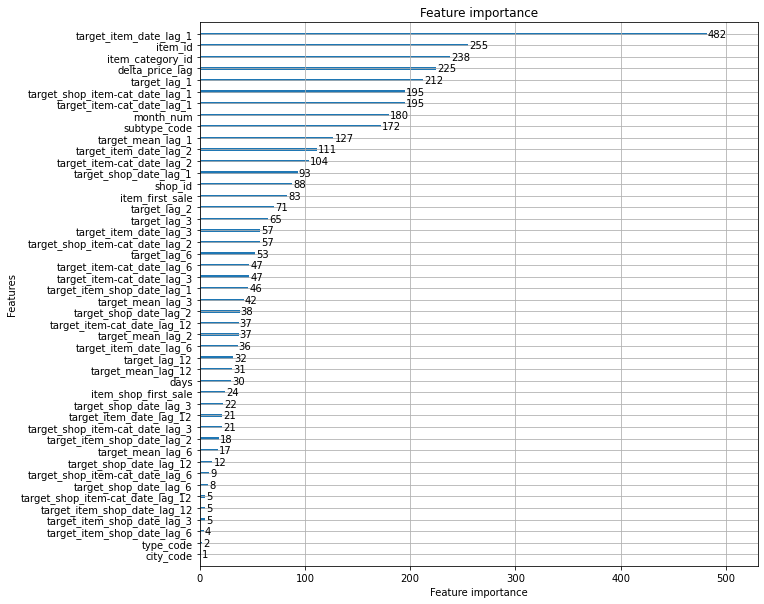

In [12]:
%%time
# LightGGM
model_lgb = lgb.LGBMRegressor(
    n_estimators=1000,
    n_jobs=-1,
    objective='mse',
    random_state=17
)
model_lgb.fit(X_train, y_train, 
              eval_set=(X_test, y_test), 
              early_stopping_rounds=100,
              verbose=100)
pred_lgb = model_lgb.predict(X_test)

print('\nTest R-squared for LightGBM is %f' % r2_score(y_test, pred_lgb))
print('Test RMSE LightGBM is %f' % np.sqrt(mean_squared_error(y_test, pred_lgb)))
print()

# Plot LightGBM features importance
fig, ax = plt.subplots(1,1,figsize=(10, 10))
lgb.plot_importance(booster=model_lgb, ax=ax)

In [13]:
if save_models:
    pickle.dump(model_lgb, open('data/sa-model_lgb.pkl', "wb"))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.239925
0:	learn: 1.0943423	test: 1.0733201	best: 1.0733201 (0)	total: 1.13s	remaining: 18m 46s
20:	learn: 0.8827077	test: 0.9454934	best: 0.9454934 (20)	total: 24.8s	remaining: 19m 15s
40:	learn: 0.8600629	test: 0.9351685	best: 0.9345706 (37)	total: 52s	remaining: 20m 16s
60:	learn: 0.8502605	test: 0.9330742	best: 0.9326933 (59)	total: 1m 17s	remaining: 19m 50s
80:	learn: 0.8403724	test: 0.9298684	best: 0.9298684 (80)	total: 1m 42s	remaining: 19m 21s
100:	learn: 0.8340127	test: 0.9291086	best: 0.9291086 (100)	total: 2m 7s	remaining: 18m 55s
120:	learn: 0.8260572	test: 0.9245310	best: 0.9245310 (120)	total: 2m 33s	remaining: 18m 37s
140:	learn: 0.8212039	test: 0.9237221	best: 0.9237221 (140)	total: 2m 58s	remaining: 18m 5s
160:	learn: 0.8168601	test: 0.9212810	best: 0.9212810 (160)	total: 3m 22s	remaining: 17m 34s
180:	learn: 0.8127396	test: 0.9217372	best: 0.9195250 (173)	total: 3m 47s	remaining: 17m 8s
200:	learn: 0.8102903	test: 0.9205581	best: 0.9195250 (173)	

<AxesSubplot:title={'center':'Feature importances'}, ylabel='Feature Id'>

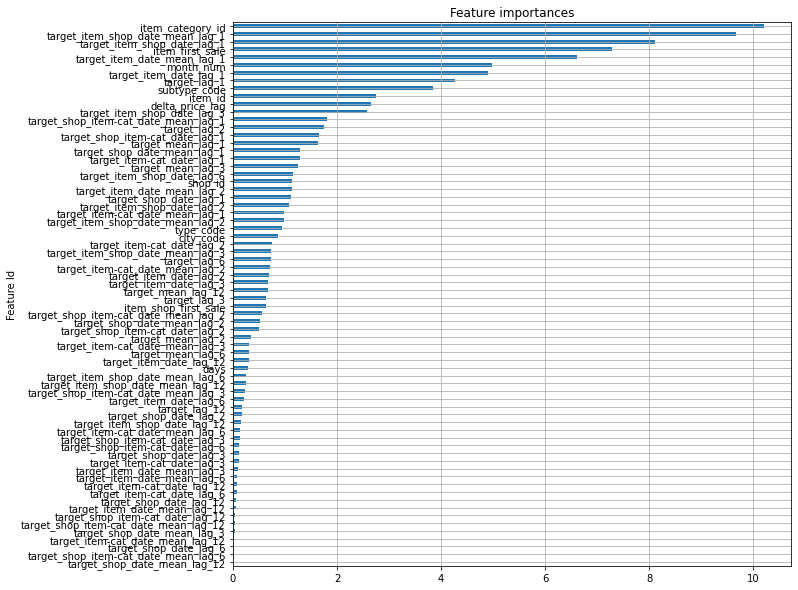

In [14]:
%%time
# Catboost

model_cbr = cb.CatBoostRegressor(loss_function='RMSE',
                                 #cat_features=cat_features,
                                 iterations=1000,
                                task_type='CPU')
model_cbr.fit(X_train, y_train, 
              eval_set=(X_test, y_test), 
              verbose=20, 
              early_stopping_rounds=50,
              plot=True)
pred_cb = model_cbr.predict(X_test)

print('\nTest R-squared for CatBoost is %f' % r2_score(y_test, pred_cb))
print('Test RMSE CatBoost is %f' % np.sqrt(mean_squared_error(y_test, pred_cb)))
print()

# Plot CatBoost features importance
f_importance = model_cbr.get_feature_importance(prettified=True)
f_importance[f_importance['Importances']>0].sort_values(by='Importances', ascending=True).set_index('Feature Id').plot(
    kind='barh', figsize=(10,10), legend=False, grid=True, title="Feature importances");

In [15]:
if save_models:
    pickle.dump(model_cbr, open('data/sa-model_cbr.pkl', "wb"))

In [16]:
# SVM
# model_svr = SVR()
# model_svr.fit(X_train.values, y_train)
# pred_svr = model_svr.predict(X_test.values, verbose=True)

# print('Test R-squared for SVR is %f' % r2_score(y_test, pred_svr))
# print('Test RMSE SVR is %f' % np.sqrt(mean_squared_error(y_test, pred_svr)))

[09:57:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1598185621802/work/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.06430	validation_1-rmse:1.05952
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 30 rounds.
[10]	validation_0-rmse:0.86458	validation_1-rmse:0.93644
[20]	validation_0-rmse:0.83920	validation_1-rmse:0.92823
[30]	validation_0-rmse:0.82902	validation_1-rmse:0.92634
[40]	validation_0-rmse:0.82227	validation_1-rmse:0.92453
[50]	validation_0-rmse:0.81568	validation_1-rmse:0.92502
[60]	validation_0-rmse:0.80709	validation_1-rmse:0.92184
[70]	validation_0-rmse:0.79991	validation_1-rmse:0.91688
[80]	validation_0-rmse:0.79636	validation_1-rmse:0.91642
[90]	validation_0-rmse:0.79137	validation_1-rmse:0.91

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

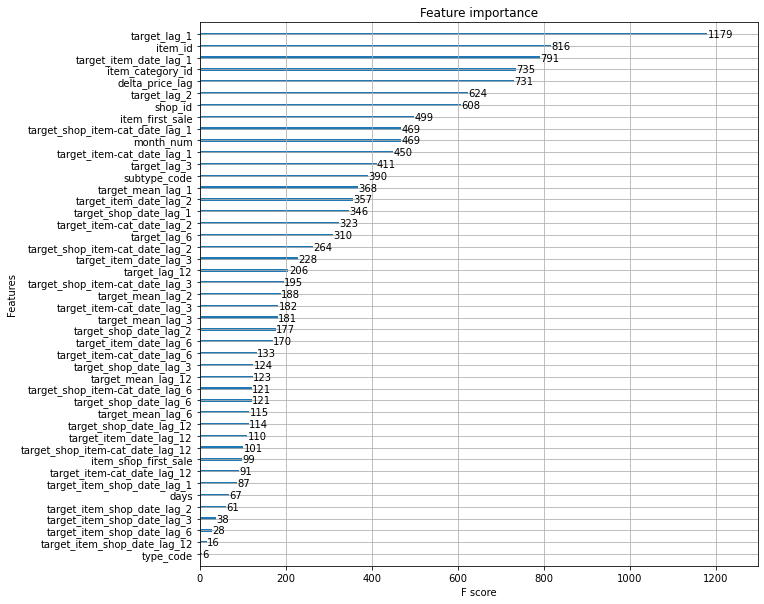

In [17]:
%%time
# XGBM
model_xgb = xgb.XGBRegressor(n_estimators=500, n_jobs=4, random_state=17)
model_xgb.fit(X_train, y_train, 
              eval_set=[(X_train, y_train), (X_test, y_test)], 
              eval_metric="rmse", 
              verbose=10, 
              early_stopping_rounds = 30)
pred_xgb = model_xgb.predict(X_test)

print('\nTest R-squared for XGBoost is %f' % r2_score(y_test, pred_xgb))
print('Test RMSE XGBoost is %f' % np.sqrt(mean_squared_error(y_test, pred_xgb)))
print()

# Plot XGBoost features importance
fig, ax = plt.subplots(1,1,figsize=(10, 10))
xgb.plot_importance(booster=model_xgb, ax=ax)

In [18]:
if save_models:
    pickle.dump(model_xgb, open('data/sa-model_xgb.pkl', "wb"))

Finally, concatenate test predictions to get test meta-features.

## Load pickled predictors 

In [19]:
# Load pickled predictors
if save_models:
    model_lr  = pickle.load(open('data/sa-model_lr.pkl', "rb"))
    model_lgb = pickle.load(open('data/sa-model_lgb.pkl', "rb"))
    model_cbr = pickle.load(open('data/sa-model_cbr.pkl', "rb"))
    model_xgb = pickle.load(open('data/sa-model_xgb.pkl', "rb"))

In [20]:
%%time
# Make predictions for test data
train_lr  = model_lr.predict(X_train)
train_lgb = model_lgb.predict(X_train)
train_cbr = model_cbr.predict(X_train)
train_xgb = model_xgb.predict(X_train)

X_train_level2 = np.c_[train_lr, train_lgb, train_cbr, train_xgb] 
# X_test_level2.tofile('X_test_level2')

CPU times: user 2min 8s, sys: 4.33 s, total: 2min 13s
Wall time: 43.1 s


In [21]:
print('Train L2 data shape:', X_train_level2.shape)
X_train_level2

Train L2 data shape: (6186922, 4)


array([[0.23969084, 0.21137401, 0.37692734, 0.33601975],
       [0.06680614, 0.17172378, 0.21957052, 0.33538261],
       [0.35189921, 0.08984224, 0.14728413, 0.20192641],
       ...,
       [0.32887926, 0.93419074, 1.52829535, 3.01213574],
       [0.3359471 , 0.19877565, 0.52115366, 0.18163797],
       [0.33594676, 0.19877565, 0.52115366, 0.18163797]])

In [22]:
%%time
# Make predictions for test data (Kaggle's test dataset)
test_lr  = model_lr.predict(X_test)
test_lgb = model_lgb.predict(X_test)
test_cbr = model_cbr.predict(X_test)
test_xgb = model_xgb.predict(X_test)

X_test_level2 = np.c_[test_lr, test_lgb, test_cbr, test_xgb]

CPU times: user 6.24 s, sys: 275 ms, total: 6.52 s
Wall time: 1.75 s


In [24]:
print('Test L2 data shape:', X_test_level2.shape)
X_test_level2

Test L2 data shape: (238172, 4)


array([[-0.03649177,  0.13078025,  0.13927869,  0.13777241],
       [ 0.04801524,  0.18403106,  0.17559693,  0.19294927],
       [ 0.17314152,  0.0372694 ,  0.04735653,  0.01318723],
       ...,
       [ 0.81852632,  0.38044405,  0.22216223,  0.31902242],
       [ 2.29918676,  2.46528685,  1.75303764,  1.28970242],
       [ 0.35332651,  0.20622116,  0.55289129,  0.18163797]])

In [25]:
%%time
# Make prediction for target data
target_lr  = model_lr.predict(X_target)
target_lgb = model_lgb.predict(X_target)
target_cbr  = model_cbr.predict(X_target)
target_xgb = model_xgb.predict(X_target)

X_target_level2 = np.c_[target_lr, target_lgb, target_cbr, target_xgb]

CPU times: user 4.79 s, sys: 239 ms, total: 5.03 s
Wall time: 1.62 s


In [26]:
print('Target L2 data shape:', X_target_level2.shape)
X_target_level2

Target L2 data shape: (214200, 4)


array([[ 0.54510194,  0.60023876,  1.02066854,  0.58100277],
       [ 0.3287233 ,  0.46315658,  0.33158085,  0.38202524],
       [ 1.18563036,  1.3228038 ,  1.77799739,  1.94452918],
       ...,
       [-0.02644037,  0.04241779,  0.03989653,  0.07222107],
       [ 0.05176524,  0.03050382,  0.04072951,  0.01499158],
       [-0.00812075,  0.02242552, -0.00478967,  0.01297557]])

In [27]:
%%time
l2_model_lr = LinearRegression()
l2_model_lr.fit(X_train_level2, y_train)
test_l2_lr = l2_model_lr.predict(X_test_level2)

print(f'Test RMSE for LinearRegression L2 is {np.sqrt(mean_squared_error(y_test, test_l2_lr))}')

Test RMSE for LinearRegression L2 is 0.924175554111446
CPU times: user 1.46 s, sys: 263 ms, total: 1.72 s
Wall time: 795 ms


In [ ]:
%%time
l2_model_cb = cb.CatBoostRegressor(loss_function='RMSE',
                               task_type='CPU')
l2_model_cb.fit(X_train_level2, y=y_train,
             eval_set=(X_test_level2, y_test),
             early_stopping_rounds=50,
             verbose=20,
             plot=True)
test_l2_cbr = l2_model_cb.predict(X_test_level2)

print(f'Test RMSE for CatBoost L2 is {np.sqrt(mean_squared_error(y_test, test_l2_cbr))}')

## Prepare data to Kaggle

In [ ]:
# Make submission
tests = pd.read_csv('../readonly/final_project_data/test.csv.gz')
export_pred = l2_model_lr.predict(X_target_level2)

kaggle_data = tests.merge(
    pd.DataFrame(np.c_[X_target[['shop_id', 'item_id']], export_pred], 
                 columns=['shop_id', 'item_id', 'item_cnt_month']) )
kaggle_data['item_cnt_month'].clip(0, 20, inplace=True)

kaggle_data[['ID', 'item_cnt_month']].to_csv('simple_ensemble.csv', index=False)

print('kaggle_data shape:', kaggle_data.shape)
kaggle_data